In [2]:
import cv2 as cv
import xarray as xr
import numpy as np
from scipy import interpolate
from sklearn.metrics import mean_absolute_error, r2_score

def inpainting(data):
    """
    Fills in missing values in the input data using inpainting techniques.
    
    Parameters:
    data (numpy.ndarray): Input array with potential NaN values.

    Returns:
    numpy.ndarray: Array with NaN values filled using inpainting, 
                   or the original array if no NaNs are present.
    """
    # Mask for NaN values
    data_copy = np.copy(data)
    na_data_mask = np.isnan(data_copy)

    # If no NaN values, return data as is
    if not na_data_mask.any():
        return data

    # Replace NaNs with the initial median value
    initial_value = np.nanmedian(data_copy)
    data_copy = data_copy.astype('float32')
    data_copy[na_data_mask] = initial_value

    # Inpainting to fill missing data
    filled_data = cv.inpaint(data_copy, na_data_mask.astype('uint8'), 10, cv.INPAINT_NS)
    return filled_data

In [3]:
def inpaint_NS(file):

    # Load datasets
    full_ds_nonull = xr.open_dataset(f'../../data/tempo_data/inpaint_experiments/no_nulls.nc', engine='netcdf4')
    unique_times, index = np.unique(full_ds_nonull['time'].values, return_index=True)
    full_ds_nonull = full_ds_nonull.isel(time=index)
    # full_ds_nonull = full_ds_nonull.isel(time=slice(0, 50))

    variable_name = 'vertical_column_troposphere'  # Replace with the actual variable name
    full_ds_nonull[variable_name] = full_ds_nonull[variable_name] / 1000000000000000

    full_ds_less1 = xr.open_dataset(f'../../data/tempo_data/inpaint_experiments/{file}.nc', engine='netcdf4')
    unique_times, index = np.unique(full_ds_less1['time'].values, return_index=True)
    full_ds_less1 = full_ds_less1.isel(time=index)
    full_ds_less1[variable_name] = full_ds_less1[variable_name] / 1000000000000000

    # Create a nan mask
    nan_mask = full_ds_less1[variable_name].isnull()
    time_dimension_nonulls = full_ds_nonull['time']
    nan_mask = nan_mask.assign_coords(time=time_dimension_nonulls)
    full_ds_nonull[f"{variable_name}_masked"] = full_ds_nonull[variable_name].where(~nan_mask)
    del full_ds_less1, unique_times, index

    inpainted_results = np.empty_like(full_ds_nonull[f"{variable_name}_masked"])

    for i in range(100):
        no2 = full_ds_nonull.isel(time=i)[f"{variable_name}_masked"]
        no2_array = np.array(no2)
        filled = inpainting(no2_array)
        # print(mean_absolute_error(full_ds_nonull.isel(time=i)[f"{variable_name}"].values, filled))
        # Assign the inpainted result to the new variable for each time step
        inpainted_results[i, :, :] = filled
        
    full_ds_nonull[f"{variable_name}_withinpaint"] = (('time', 'latitude', 'longitude'), inpainted_results)

    # # Extract original values (masked by nan_mask)
    original_values = full_ds_nonull.where(nan_mask)[variable_name].values
    original_flat = original_values[nan_mask.values]

    biharmonic_values = full_ds_nonull[f"{variable_name}_withinpaint"].values
    inpainted_flat = biharmonic_values[nan_mask.values]

    mae = mean_absolute_error(original_flat, inpainted_flat)
    r2 = r2_score(original_flat, inpainted_flat)

    print("mae: ", mae)
    print("r2: ", r2)
    # return(mae, r2, full_ds_nonull)

In [4]:
inpaint_NS('nulls_less1perc')

mae:  0.762094190716385
r2:  0.8707358555631841


In [5]:
inpaint_NS('nulls_less5perc')

mae:  0.8469959513609915
r2:  0.768427661527178


In [6]:
inpaint_NS('nulls_less10perc')

mae:  0.9585203229193022
r2:  0.5436267305154077


In [7]:
inpaint_NS('nulls_less25perc')

mae:  1.2011363830638502
r2:  0.5556960701184857


In [8]:
inpaint_NS('nulls_less50perc')

mae:  1.3317325611513937
r2:  0.0667595374590998


In [9]:
inpaint_NS('nulls_over50perc')

/var/tmp/ipykernel_48537/2533245383.py:27: RuntimeWarning: All-NaN slice encountered
  initial_value = np.nanmedian(data_copy)


ValueError: Input contains NaN.

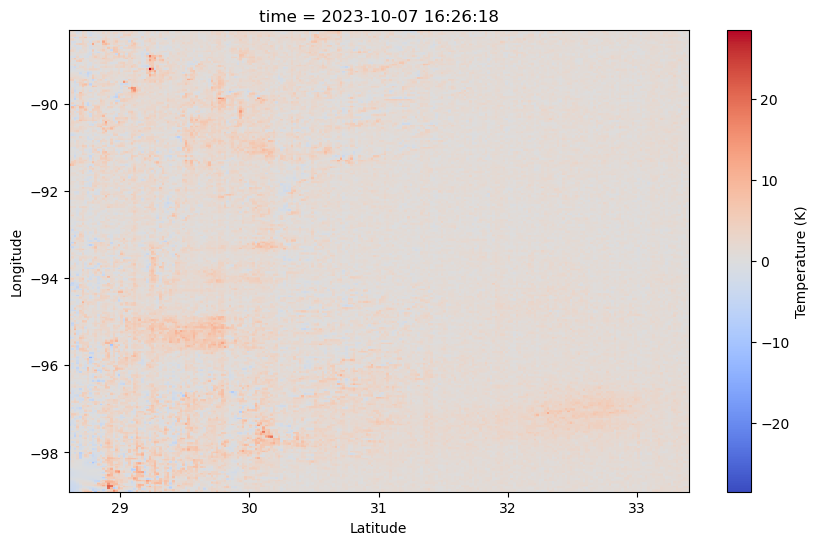

In [4]:
import matplotlib.pyplot as plt
variable_name = 'vertical_column_troposphere'
# # Define your latitude and longitude bounds
# lat_min, lat_max = 28.6, 33.4  # Example latitude range
# lon_min, lon_max = -98.9, -88.3  # Example longitude range

# Select one hour of temperature data (e.g., the first timestamp)
hour_index = 2 #Change this to select a different hour if desired
temperature_data = ds[f"{variable_name}_withinpaint"].isel(time=8)
# temperature_data = ds['Percent_Tree_Cover']

# Plot the data with switched axes
plt.figure(figsize=(10, 6))

# Plot with latitude on x-axis and longitude on y-axis
temperature_data.T.plot(
    cmap="coolwarm",  # Colormap for temperature visualization
    cbar_kwargs={'label': 'Temperature (K)'}  # Add color bar label
)

# Update axis labels
plt.xlabel("Latitude")
plt.ylabel("Longitude")

plt.show()

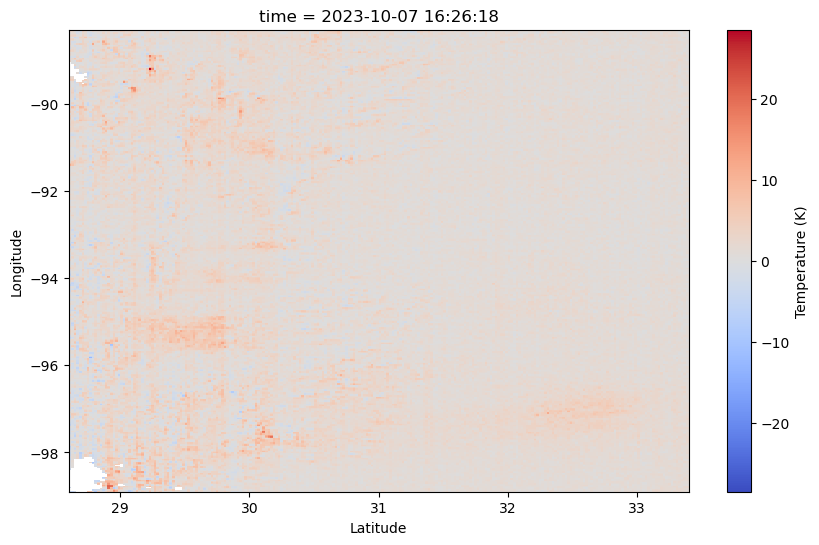

In [5]:
import matplotlib.pyplot as plt
# # Define your latitude and longitude bounds
# lat_min, lat_max = 28.6, 33.4  # Example latitude range
# lon_min, lon_max = -98.9, -88.3  # Example longitude range

# Select one hour of temperature data (e.g., the first timestamp)
hour_index = 0 #Change this to select a different hour if desired
temperature_data = ds[f"{variable_name}_masked"].isel(time=8)
# temperature_data = ds['Percent_Tree_Cover']

# Plot the data with switched axes
plt.figure(figsize=(10, 6))

# Plot with latitude on x-axis and longitude on y-axis
temperature_data.T.plot(
    cmap="coolwarm",  # Colormap for temperature visualization
    cbar_kwargs={'label': 'Temperature (K)'}  # Add color bar label
)

# Update axis labels
plt.xlabel("Latitude")
plt.ylabel("Longitude")

plt.show()